In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

Using Theano backend.


In [2]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('capstone.db')
# tblGame , tblMovie, tblReview, tblTVShow
# load games dataset
games = pd.read_sql_query("SELECT * FROM tblGame;", conn)
games['gameID'] = games.index + 1
reviews = pd.read_sql_query("SELECT * FROM tblReview;", conn)

In [3]:
critic_reviews = reviews[reviews['reviewType'] == 'c']


In [4]:
import re

#longest review 203 words

def cleaning_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'\\r, u', ' ', sentence)
    sentence = re.sub(r'\\', "'", sentence)
    sentence = sentence.split()
    sentence = [re.sub("([^a-z0-9' \t])", '', x) for x in sentence]
    cleaned = [s for s in sentence if s != '']
    cleaned = ' '.join(cleaned)
    return cleaned

                        
critic_reviews['textClean'] = critic_reviews.apply(lambda row: cleaning_text(row['text'].encode("utf8")), axis=1)

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


75.0
19.3140135003
106045
96010


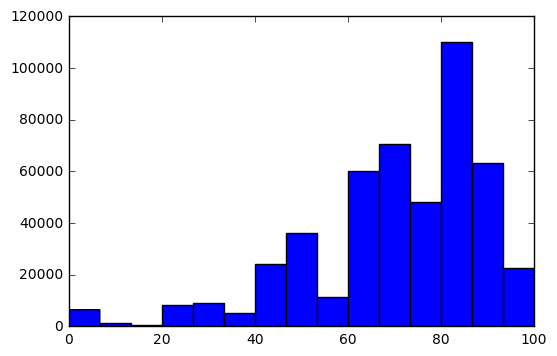

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

print critic_reviews['score'].median()
print critic_reviews['score'].std()
plt.hist(critic_reviews['score'], bins = 15)
print len(critic_reviews[critic_reviews['score'] >= (85)])
print len(critic_reviews[critic_reviews['score'] <= (55)])

In [6]:
#label reviews 85 or over as positive and 55 or lower as negative

def binarizer(x):
    if x <= 55:
        return 0
    if x >= 85:
        return 1
    
critic_reviews['overall'] = critic_reviews['score'].apply(lambda row: binarizer(row))

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
import numpy as np

#drop rows with NA values for overall (scores between 55 and 85)
subset = critic_reviews[pd.notnull(critic_reviews['overall'])].reset_index()

subset = subset.drop(['author', 'text', 'score', 'date', 'thumbsUp', 'thumbsDown', 'reviewType'], axis = 1).reset_index()
len(subset)

202055

In [8]:

subset.head(3)

,level_0,index,gameID,movieID,tvShowID,publication,textClean,overall
0,0,4,1.0,NaN,NaN,Digitally Downloaded,it may sound like im being harsh on ginger but...,0.0
1,1,5,2.0,NaN,NaN,God is a Geek,jojos bizarre adventure eyes in heaven feature...,1.0
2,2,31,2.0,NaN,NaN,PSX-Sense.nl,the amount of fan service is both admirable an...,0.0


In [9]:
max_features = 10000
# cut texts after this number of words 
max_length = 203
batch_size = 32

In [11]:
from keras.preprocessing import text
import keras 

tk = text.Tokenizer(max_features, filters=keras.preprocessing.text.base_filter(), split=" ")
tk.fit_on_texts(subset['textClean'])

#create data set, both features and labels
x = tk.texts_to_sequences(subset['textClean'])
y = subset['overall']

In [12]:
x = sequence.pad_sequences(x, maxlen = max_length, padding = 'post')

In [13]:
subset['textClean'][1]

'jojos bizarre adventure eyes in heaven features fun combat and a crazy story youll find hard not to get sucked into'

In [14]:
x[1]

array([1671,  151, 1063,    8, 2553,  233,   49,  163,    3,    2, 1104,
         62,  326,  134,  183,   23,    5,   80, 4338,   64,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [15]:
#Divide dataset into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
x, y, test_size=0.4, random_state=42)

In [16]:
print len(X_train), len(X_test), len(y_train), len(y_test)
X_train.shape

#Training data shape: 121233, 203
#Test data shape: 80822, 203
y_test[1:3]
print max_features

121233 80822 121233 80822
10000


In [26]:
#create the model, convolution 

#default gets 88% accuracy, embedding = 32, filter length = 3, pool length = 2, dense = 250, 2 epoch, batch size = 128
#second attempt: 89.3% accuracy, log loss = 0.2701, embedding = 32, filter length = 4, pool length = 4, dense = 500, 3 epoch, batch size = 256
embedding_vector_length = 32
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=32, filter_length=4, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=4))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=256, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 203, 32)       320000      embedding_input_5[0][0]          
____________________________________________________________________________________________________
convolution1d_3 (Convolution1D)  (None, 203, 32)       4128        embedding_5[0][0]                
____________________________________________________________________________________________________
maxpooling1d_3 (MaxPooling1D)    (None, 50, 32)        0           convolution1d_3[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 1600)          0           maxpooling1d_3[0][0]             
___________________________________________________________________________________________

In [96]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 10000 
max_length = 203
embedding_vector_length = 128

kernel_size = 5
filters = 64
pool_size = 4

ltsm_output_size = 70

batch_size = 30
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_60 (Embedding)         (None, 203, 128)      1280000     embedding_input_60[0][0]         
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 203, 128)      0           embedding_60[0][0]               
____________________________________________________________________________________________________
convolution1d_32 (Convolution1D) (None, 199, 64)       41024       dropout_8[0][0]                  
____________________________________________________________________________________________________
maxpooling1d_28 (MaxPooling1D)   (None, 49, 64)        0           convolution1d_32[0][0]           
___________________________________________________________________________________________

In [99]:
max_features = 10000 
max_length = 203
embedding_vector_length = 200

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 25

batch_size = 50
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=batch_size, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_63 (Embedding)         (None, 203, 200)      2000000     embedding_input_63[0][0]         
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 203, 200)      0           embedding_63[0][0]               
____________________________________________________________________________________________________
convolution1d_35 (Convolution1D) (None, 200, 64)       51264       dropout_11[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_31 (MaxPooling1D)   (None, 50, 64)        0           convolution1d_35[0][0]           
___________________________________________________________________________________________

In [109]:
max_features = 10000 
max_length = 203
embedding_vector_length = 128

kernel_size = 8
filters = 64
pool_size = 4

ltsm_output_size = 25

batch_size = 50
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(Conv1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size / 2))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=batch_size, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_73 (Embedding)         (None, 203, 128)      1280000     embedding_input_73[0][0]         
____________________________________________________________________________________________________
dropout_22 (Dropout)             (None, 203, 128)      0           embedding_73[0][0]               
____________________________________________________________________________________________________
convolution1d_57 (Convolution1D) (None, 196, 64)       65600       dropout_22[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_49 (MaxPooling1D)   (None, 49, 64)        0           convolution1d_57[0][0]           
___________________________________________________________________________________________

In [22]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 10000 
max_length = 203
embedding_vector_length = 128

kernel_size = 8
filters = 128
pool_size = 4

ltsm_output_size = 20

batch_size = 30
epochs = 6

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Conv1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(Conv1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size / 2))
model.add(LSTM(ltsm_output_size, return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(ltsm_output_size, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=batch_size, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 203, 128)      1280000     embedding_input_5[0][0]          
____________________________________________________________________________________________________
convolution1d_9 (Convolution1D)  (None, 196, 128)      131200      embedding_5[0][0]                
____________________________________________________________________________________________________
maxpooling1d_9 (MaxPooling1D)    (None, 49, 128)       0           convolution1d_9[0][0]            
____________________________________________________________________________________________________
convolution1d_10 (Convolution1D) (None, 42, 128)       131200      maxpooling1d_9[0][0]             
___________________________________________________________________________________________

In [23]:
weights = model.save_weights

In [21]:
weights

<bound method Sequential.save_weights of <keras.models.Sequential object at 0x16754bd10>>

In [62]:
model.save('sentiment_model2.h5')

In [69]:
from keras.preprocessing import text
import keras 

text_test = 'This is a great game! I love it. THe graphics are really good and the combat is super smooth'
text_test2 = 'Ugh, this game is not good. I would not recommend it'
tester = subset['textClean'][1]
print tester

cleaned = cleaning_text(text_test)
cleaned2 = cleaning_text(text_test2)

print cleaned2

#create data set, both features and labels
x = tk.texts_to_sequences([cleaned2, cleaned, tester])

print x[0]

x = sequence.pad_sequences(x, maxlen = max_length, padding = 'post')

print x[0].shape

print len(x)
print(x)



jojos bizarre adventure eyes in heaven features fun combat and a crazy story youll find hard not to get sucked into
ugh this game is not good i would not recommend it
[14, 10, 6, 23, 55, 30, 104, 23, 322, 7]
(203,)
3
[[  14   10    6   23   55   30  104   23  322    7    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  

In [70]:
preds = model.predict(x[0])
round(preds[1])

Exception: Error when checking : expected embedding_input_3 to have shape (None, 203) but got array with shape (203, 1)

In [18]:
import pickle
#pickle.dump(tk, open("tk.pickle", "wb"))
with open('tk.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [74]:
input_str = 'I did not love it!'
rating = 2

def sentiment_predictor(input_str, rating):
    dummy = ''
    cleaned = cleaning_text(input_str)
    sequences = tk.texts_to_sequences([dummy, cleaned])
    padded_sequences = sequence.pad_sequences(sequences, maxlen = 203, padding = 'post')
    #drop_dummy = padded_sequences[1]
    #print drop_dummy.shape
    preds = model.predict(padded_sequences)


    #either 0 or 1
    predicted_rating = round(preds[1])
    print predicted_rating 
    
    if rating < 6 and predicted_rating == 1:
        return 'Are you sure about that score? It seemed like you liked it'
    elif rating > 8 and predicted_rating == 0:
        return "Hmm, it seems like you don't really like this game, are you sure about that rating?"

sentiment_predictor(input_str, rating)

0.0
